# Model & Evaluation

## 1. Load Packages and Datasets

In [72]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
from collections import Counter
%matplotlib inline

from dateutil import parser
from presidio_analyzer import (
    AnalyzerEngine,
    EntityRecognizer,
    PatternRecognizer,
    Pattern,
    RecognizerResult
)
from presidio_analyzer.context_aware_enhancers import LemmaContextAwareEnhancer
from presidio_analyzer.nlp_engine import NlpArtifacts, NlpEngineProvider
#from presidio_analyzer.predefined_recognizers import EmailRecognizer, UrlRecognizer, PhoneRecognizer
from presidio_analyzer.recognizer_registry import RecognizerRegistry

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.exceptions import UndefinedMetricWarning

# Other Models
import xgboost as xgb
from nltk.corpus import stopwords
#from imblearn.over_sampling import SMOTE

In [45]:
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [3]:
# Load pre-processed train and test set from EDA notebook
train_df = pd.read_json('./../data/preprocess_train.json')
test_df = pd.read_json('./../data/preprocess_test.json')

raw_train_df = pd.read_json('./../data/train.json')
raw_test_df = pd.read_json('./../data/test.json')

## 2. Model Building

In [50]:
# Convert list of tokens back to strings
train_df['tokens_joined'] = train_df['tokens_processed'].apply(lambda tokens: ' '.join(tokens))

# Extract features and labels
X = train_df['tokens_joined']
y = train_df['labels_processed']

mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y)

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

# Train-valid split
X_train, X_valid, y_train, y_valid = train_test_split(X_tfidf, y_bin, test_size=0.2, random_state=599)

# Used for models that require 1D train/validation
y_train_argmax = np.argmax(y_train, axis=1)
y_valid_argmax = np.argmax(y_valid, axis=1)

In [5]:
# Verify shape of dataset
print("Shape of X_train:", X_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_valid:", y_valid.shape)

Shape of X_train: (5445, 37843)
Shape of X_valid: (1362, 37843)
Shape of y_train: (5445, 13)
Shape of y_valid: (1362, 13)


In [6]:
# Create function to run classification report and collect performance metrics
def evaluate(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    print('Accuracy Score:', acc, '\n')

    report = classification_report(y, y_pred)
    print('Classification Report:')
    print(report)

### 2.1 Logistic Regression Model

In [7]:
start_time = time.time()

logreg_model = LogisticRegression(max_iter=1000, random_state=599)
logreg_model.fit(X_train, y_train_argmax)

y_pred_logreg = logreg_model.predict(X_valid)

end_time = time.time()

In [8]:
runtime_lg = end_time - start_time
print("Model runtime:", runtime_lg, "seconds")
evaluate(y_valid_argmax, y_pred_logreg)

Model runtime: 2.4524049758911133 seconds
Accuracy Score: 0.86 

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00       168
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         2
          12       0.86      1.00      0.93      1172

    accuracy                           0.86      1362
   macro avg       0.12      0.14      0.13      1362
weighted avg       0.74      0.86      0.80      1362



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.2 Random Forest Model
#### 2.2.1 Using 100 Estimators

In [59]:
start_time = time.time()

# Baseline model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=599)
rf_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_rf = rf_classifier.predict(X_valid)

end_time = time.time()

In [60]:
runtime_rf = end_time - start_time
print("Model runtime:", runtime_rf, "seconds")
evaluate(y_valid, y_pred_rf)

Model runtime: 15.600973129272461 seconds
Accuracy Score: 0.86 

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        12
           2       1.00      0.01      0.01       183
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00       169
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       1.00      1.00      1.00      1362

   micro avg       1.00      0.78      0.88      1744
   macro avg       0.15      0.08      0.08      1744
weighted avg       0.89      0.78      0.78   

#### 2.2.2 Parameter Tuning with GridSearch

In [61]:
# Hyperparameter tuning for RF
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=599)
rf_classifier.fit(X_train, y_train)

# Grid search model
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, n_jobs=-1,
                           cv=3, verbose=2, scoring='f1')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

Best parameters found:  {'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


In [62]:
final_rf_model = RandomForestClassifier(**best_params)
final_rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_rf_grid = final_rf_model.predict(X_valid)

end_time = time.time()

In [63]:
# Evaluate the model
runtime_rf_grid = end_time - start_time
print("Model runtime:", runtime_rf_grid, "seconds")
evaluate(y_valid, y_pred_rf_grid)

Model runtime: 299.8314538002014 seconds
Accuracy Score: 0.86 

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00       183
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00       169
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       1.00      1.00      1.00      1362

   micro avg       1.00      0.78      0.88      1744
   macro avg       0.08      0.08      0.08      1744
weighted avg       0.78      0.78      0.78    

### 2.3 K-Nearest Neighbors Model

#### 2.3.1 Tuning with K Parameter

In [14]:
# Tuning K Parameter
train_score = {}
valid_score = {}
n_neighbors = np.arange(2, 30, 1) #2-29 neighbors

start_time = time.time()
for neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_score[neighbor]=knn.score(X_train, y_train)
    valid_score[neighbor]=knn.score(X_valid, y_valid)

In [15]:
for best_k, value in valid_score.items():
    if value==max(valid_score.values()):
        print("Optimal K:", best_k)

Optimal K: 10
Optimal K: 11


In [16]:
knn_classifier = KNeighborsClassifier(n_neighbors=10)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_knn = knn_classifier.predict(X_valid)
end_time = time.time()

In [17]:
# Evaluate the model
runtime_knn = end_time - start_time
print("Model runtime:", runtime_knn, "seconds")
evaluate(y_valid, y_pred_knn)

Model runtime: 140.65211129188538 seconds
Accuracy Score: 0.86 

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      0.08      0.15        12
           2       1.00      0.01      0.01       183
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       1.00      0.01      0.01       169
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       1.00      1.00      1.00      1362

   micro avg       1.00      0.78      0.88      1744
   macro avg       0.31      0.08      0.09      1744
weighted avg       0.99      0.78      0.78   

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


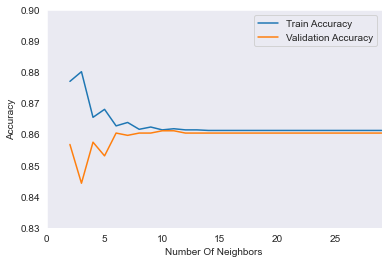

In [18]:
plt.plot(n_neighbors, train_score.values(), label="Train Accuracy")
plt.plot(n_neighbors, valid_score.values(), label="Validation Accuracy")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy")
plt.legend()
plt.xlim(0, 29)
plt.ylim(0.83, 0.90)
plt.grid()
plt.show()

#### 2.3.2 Parameter Tuning with GridSearch

In [97]:
# Hyperparameter tuning with GridSearch
kf=KFold(n_splits=5,shuffle=True,random_state=42)
estimator_knn = KNeighborsClassifier(algorithm='auto')
param_grid_knn = {
    'n_neighbors': np.arange(2, 30, 1),
}

start_time = time.time()

# Instantiate GridSearchCV
grid_search_knn = GridSearchCV(estimator=estimator_knn,
                               param_grid=param_grid_knn,
                               verbose=1,
                               cv = kf)

# Perform grid search to find the best parameters
grid_search_knn.fit(X_train, y_train)

# Get the best parameters
print(grid_search_knn.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'n_neighbors': 10}


In [98]:
final_knn_model = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'])

# Train the model on the training data
final_knn_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_knn_grid = final_knn_model.predict(X_valid)

end_time = time.time()

In [99]:
# Evaluate the model
runtime_knn_grid = end_time - start_time
print("Model runtime:", runtime_knn_grid, "seconds")
# Calculate accuracy
accuracy = accuracy_score(y_valid, y_pred_knn_grid)
print("Accuracy:", accuracy)

# Evaluate the model
print(classification_report(y_valid, y_pred_knn_grid))

Model runtime: 100.04701900482178 seconds
Accuracy: 0.8612334801762115
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      0.08      0.15        12
           2       1.00      0.01      0.01       183
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       1.00      0.01      0.01       169
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       1.00      1.00      1.00      1362

   micro avg       1.00      0.78      0.88      1744
   macro avg       0.31      0.08      0.09      1744
weighted avg       0.99      0.78      0.78      1744
 samples 

### 2.4 XGBoost Model

In [22]:
xgb_model = xgb.XGBClassifier()
y_train_argmax = np.argmax(y_train, axis=1)
y_valid_argmax = np.argmax(y_valid, axis=1)

xgb_model.fit(X_train, y_train_argmax)

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0]
}
start_time = time.time()
# Randomized search
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                n_iter=10, cv=3, verbose=2, random_state=599, n_jobs=-1)

# Find best parameters
random_search.fit(X_train, y_train_argmax)
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting wi

[14:54:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01}


In [24]:
from xgboost import XGBClassifier

final_xgb_model = XGBClassifier(**best_params)
final_xgb_model.fit(X_train, y_train_argmax)

# Make predictions on the validation set
y_pred_xgb = final_xgb_model.predict(X_valid)

end_time = time.time()

[14:55:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [41]:
# Evaluate the model
runtime_xgb = end_time - start_time
print("Model runtime:", runtime_xgb, "seconds")
evaluate(y_valid_argmax, y_pred_xgb)

Model runtime: 781.8271389007568 seconds
Accuracy Score: 0.86 

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      0.25      0.40        12
           2       0.43      0.02      0.03       168
           4       0.00      0.00      0.00         1
           5       0.25      0.33      0.29         3
           6       0.00      0.00      0.00         2
          12       0.87      1.00      0.93      1172

    accuracy                           0.86      1362
   macro avg       0.51      0.34      0.36      1362
weighted avg       0.81      0.86      0.81      1362



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.5 Presidio Model

In [77]:
# Loading Names Datasets
us_names = pd.read_csv('./../data/NationalNames.csv')['Name'].str.upper().unique()

nltk_female = open('./../data/names/female.txt').read().split('\n')
nltk_male = open('./../data/names/male.txt').read().split('\n')

nltk_female = [i.upper() for i in nltk_female]
nltk_male = [i.upper() for i in nltk_male]

french_dept = pd.read_csv('./../data/departmental_names.csv')['name'].str.upper().unique()
french_nat = pd.read_csv('./../data/national_names.csv')['name'].str.upper().unique()

wikipedia = pd.read_csv('./../data/people_wiki.csv')['name'].str.upper().tolist()

In [78]:
x = pd.DataFrame(train_df)
y = x['labels']
y = train_df['labels']
x = x.drop(columns='labels')
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.2, random_state=599)

In [79]:
# Functions for Presidio
def token_index(row):
    tokens  = row['tokens']
    start_ind = []
    end_ind = []
    prev_ind = 0
    for tok in tokens:
        start = prev_ind + row['full_text'][prev_ind:].index(tok)
        end = start+len(tok)
        start_ind.append(start)
        end_ind.append(end)
        prev_ind = end
    return start_ind, end_ind

def find_larger(arr, target):
    left, right = 0, len(arr) - 1

    while left <= right:
        mid = (left + right) // 2

        if arr[mid] == target:
            return mid
        elif arr[mid] < target:
            left = mid + 1
        else:
            right = mid - 1
    return left

def count_whitespaces(word):
    return len(word) - len(word.rstrip())

def date_check(text):
    try:
        parsed_date = parser.parse(text)
        return True
    except:
        return False


def pii_fbeta_score(pred_df, gt_df,beta=5):
    df = pred_df.merge(gt_df,how='outer',on=['document',"token"],suffixes=('_pred','_gt'))

    df['cm'] = ""

    df.loc[df.label_gt.isna(),'cm'] = "FP"
    df.loc[df.label_pred.isna(),'cm'] = "FN"
    df.loc[(df.label_gt.notna()) & (df.label_gt!=df.label_pred),'cm'] = "FN"

    df.loc[(df.label_pred.notna()) & (df.label_gt.notna()) & (df.label_gt==df.label_pred),'cm'] = "TP"

    FP = (df['cm']=="FP").sum()
    FN = (df['cm']=="FN").sum()
    TP = (df['cm']=="TP").sum()

    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    f1 = precision * recall / (precision + recall)

    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F1-Score: " + str(f1))

    s_micro = (1+(beta**2))*TP/(((1+(beta**2))*TP) + ((beta**2)*FN) + FP)

    return s_micro

In [80]:
ALLOW_LIST = []
DENY_LIST_EMAIL = []
DENY_LIST_ADDRESS = []
DENY_LIST_URL = []
DENY_LIST_NAME = []
DENY_LIST_PHONE = []
DENY_LIST_ID = []

In [81]:
all_stopwords = list(stopwords.words())
words = Counter()
for doc in train_x.tokens:
    words.update(doc)
for doc in val_x.tokens:
    words.update(doc)
all_stopwords  += [str(w).lower() for w, i in words.items() if i > 55]
all_stopwords = list(sorted(set(all_stopwords)))
del words

ALLOW_LIST.extend(all_stopwords)

In [82]:
PHONE_ALLOW_LIST = ['phone', 'number', 'telephone', 'cell', 'cellphone',
                    'mobile', 'call', 'ph', 'tel', 'mobile', 'Email']
URL_DENY_LIST = ["wikipedia", "coursera", ".pdf", ".PDF", "article",
                 ".png",".gov", ".work", ".ai", ".firm", ".arts",
                 ".store", ".rec", ".biz", ".travel", '.ru', 'designabetterbusiness', '.tools', 'designorate',
                 'designresearchtechniques', 'ec', '.europa', 'forbes', 'google',
                 'ideas', 'trello', '.edu']

In [83]:
#Prepping the list of datasets for PII
DENY_LIST_NAME.extend(us_names)
DENY_LIST_NAME.extend(nltk_female)
DENY_LIST_NAME.extend(nltk_male)
DENY_LIST_NAME.extend(french_dept)
DENY_LIST_NAME.extend(french_nat)

tokens = train_x['tokens'].apply(pd.Series).stack().reset_index(drop=True).tolist()
labels = train_y.apply(pd.Series).stack().reset_index(drop=True).tolist()

#tokens = train['tokens'].apply(pd.Series).stack().reset_index(drop=True).tolist()
#labels = train['labels'].apply(pd.Series).stack().reset_index(drop=True).tolist()

for i in set(labels):
    indices = [j for j in range(len(labels)) if labels[j] == i]
    if i == 'O':
        ALLOW_LIST.extend([tokens[i] for i in indices])
    if i == 'B-EMAIL':
        DENY_LIST_EMAIL.extend([tokens[i] for i in indices])
    elif i in ['B-STREET_ADDRESS', 'I-STREET_ADDRESS']:
        DENY_LIST_ADDRESS.extend([tokens[i] for i in indices])
    elif i in ['B-URL_PERSONAL', 'I-URL_PERSONAL']:
        DENY_LIST_URL.extend([tokens[i] for i in indices])
    elif i in ['B-NAME_STUDENT', 'I-NAME_STUDENT']:
        #elif i in ['I-NAME_STUDENT']:
        DENY_LIST_NAME.extend([tokens[i] for i in indices])
    elif i in ['B-PHONE_NUM', 'I-PHONE_NUM']:
        DENY_LIST_PHONE.extend([tokens[i] for i in indices])
    elif i in ['B-ID_NUM', 'I-ID_NUM']:
        DENY_LIST_ID.extend([tokens[i] for i in indices])
    else:
        continue

In [84]:
id_regex = r'([A-Za-z]{2}[.?]:)?\d{12,12}'
id_pattern = Pattern(name="id", regex=id_regex, score = 0.5)
id_recognizer = PatternRecognizer(supported_entity="ID_CUSTOM", patterns = [id_pattern])

address_regex = r'\b\d+\s+\w+(\s+\w+)*\s+((st(\.)?)|(ave(\.)?)|(cir(\.)?)|(rd(\.)?)|(blvd(\.)?)|(ln(\.)?)|(ct(\.)?)|(dr(\.)?))\b'
address_pattern = Pattern(name="address", regex=address_regex, score=0.5)
address_recognizer = PatternRecognizer(supported_entity="ADDRESS_CUSTOM", patterns = [address_pattern], context=["st", "Apt"])

email_regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
email_pattern = Pattern(name="email address", regex=email_regex, score=0.5)
email_recognizer = PatternRecognizer(supported_entity="EMAIL_CUSTOM", patterns = [email_pattern])

url_regex = r'((https?)|(http?)|(ftp?))://\S+|www\.\S+'
url_pattern = Pattern(name="url", regex=url_regex, score=0.5)
url_recognizer = PatternRecognizer(supported_entity="URL_CUSTOM", patterns = [url_pattern])

phone_regex = r'^[\+]?[(]?[0-9]{3}[)]?[-\s\.]?[0-9]{3}[-\s\.]?[0-9]{4,6}$'
phone_pattern = Pattern(name='phone', regex=phone_regex, score=0.5)
phone_recognizer = PatternRecognizer(supported_entity='PHONE_CUSTOM', patterns=[phone_pattern])

In [85]:
configuration = {
    "nlp_engine_name": "spacy",
    "models": [{"lang_code": "en", "model_name": "en_core_web_lg"}],
}
provider = NlpEngineProvider(nlp_configuration=configuration)
nlp_engine = provider.create_engine()

In [86]:
dictionary = RecognizerRegistry()
dictionary.load_predefined_recognizers()
dictionary.add_recognizer(address_recognizer)
dictionary.add_recognizer(email_recognizer)
dictionary.add_recognizer(url_recognizer)
dictionary.add_recognizer(phone_recognizer)
dictionary.add_recognizer(id_recognizer)

In [87]:
analyzer = AnalyzerEngine(supported_languages=['en'],
                          registry=dictionary,
                          nlp_engine=nlp_engine,
                          context_aware_enhancer=LemmaContextAwareEnhancer(
                              context_similarity_factor=0.6,
                              min_score_with_context_similarity=0.4
                          ))

In [88]:
preds = []
#test = preprocessed_test
test = val_x
temp = test.apply(lambda x: token_index(x), axis=1)
test['start'] = temp.apply(lambda x: x[0])
test['end'] = temp.apply(lambda x: x[1])

In [89]:
start_time = time.time()

for i, d in enumerate(tqdm(test.iterrows())):
    results = analyzer.analyze(text=d[1]['full_text'],
                               entities=["PHONE_CUSTOM", "PERSON", "URL_CUSTOM", "EMAIL_ADDRESS",
                                         "EMAIL_CUSTOM", "ADDRESS_CUSTOM", "US_SSN", "US_ITIN",
                                         "US_PASSPORT", "US_BANK_NUMBER", "USERNAME", "ID_CUSTOM"],
                               allow_list=ALLOW_LIST,
                               language='en',
                               score_threshold=0.005)
    pre_preds = []
    for r in results:
        s = find_larger(d[1]['start'], r.start)
        end = r.end
        word = d[1]['full_text'][r.start:r.end]
        end = end - count_whitespaces(word)
        temp_preds = [s]
        try:
            while d[1]['end'][s+1] <= end:
                temp_preds.append(s+1)
                s +=1
        except:
            pass

        tmp = False

        if r.entity_type == 'PHONE_CUSTOM':
            if date_check(word):
                continue
            for w in PHONE_ALLOW_LIST:
                if w in d[1]['full_text'][max(r.start-50, 0):min(r.end+50, len(d[1]['full_text']))]:
                    tmp = False
                    break
                else:
                    tmp = True
            label =  'PHONE_NUM'
        if r.entity_type == 'PERSON':
            if str(i).upper() in wikipedia:
                tmp = True
                break
            label =  'NAME_STUDENT'
        if r.entity_type == 'URL_CUSTOM':
            for w in URL_DENY_LIST:
                if w in word:
                    tmp = True
                    break
            label = 'URL_PERSONAL'
        if r.entity_type == 'EMAIL_ADDRESS' or r.entity_type == 'EMAIL_CUSTOM':
            label = "EMAIL"
        if r.entity_type == 'ADDRESS_CUSTOM':
            label = 'STREET_ADDRESS'
        if r.entity_type in ['US_SSN', 'US_ITIN', 'US_PASSPORT', 'US_BANK_NUMBER', 'ID_CUSTOM']:
            label = 'ID_NUM'
        if r.entity_type == 'USERNAME':
            label =  'USERNAME'
        if tmp:
            continue
        for p in temp_preds:
            if len(pre_preds) > 0:
                if pre_preds[-1]['rlabel'] == r.entity_type and ((p - pre_preds[-1]['token'])==1):
                    label_f = "I-"+label
                else:
                    label_f = "B-"+label
            else:
                label_f = "B-"+label
            pre_preds.append(({
                "document":d[1]['document'],
                "token":p,
                "label":label_f,
                "rlabel":r.entity_type
            }))
    preds.extend(pre_preds)

0it [00:00, ?it/s]

In [90]:
predicted_results = pd.DataFrame(preds).iloc[:,:-1].reset_index()
predicted_results.columns = ['row_id','document', 'token', 'label']

temp = val_x[['document']].join(val_y)
dictionary = temp['labels'].apply(lambda x: {'indx': list(range(len(x))), 'vals': x})
indices = dictionary.apply(lambda x: x['indx']).explode()
values = dictionary.apply(lambda x: x['vals']).explode()
ground_truth = pd.concat([indices, values], axis=1).reset_index()
ground_truth['document'] = ground_truth['index'].apply(lambda x: temp['document'][x])
ground_truth = ground_truth.drop(columns='index')
ground_truth.columns = ['token', 'label', 'document']
ground_truth = ground_truth[ground_truth['label'] != 'O']
ground_truth = ground_truth.reset_index(names=['row_id'])

end_time = time.time()

In [91]:
# Evaluate the model
runtime_presidio_analyzer = end_time - start_time
print("Model runtime:", runtime_presidio_analyzer, "seconds")
print("FBeta Score: " + str(pii_fbeta_score(predicted_results, ground_truth, 1)))

Model runtime: 189.52753496170044 seconds
Precision: 0.2889755011135857
Recall: 0.8564356435643564
F1-Score: 0.21606994171523725
FBeta Score: 0.4321398834304746


## 3. Evaluate Models

In [100]:
# Store runtime results
model_names = ['Logistic Regression',
               'Random Forest',
               'Random Forest - GridSearch',
               'K-Nearest Neighbors',
               'K-Nearest Neighbors - GridSearch',
               'XGBoost - RandomSearch',
               'Presidio Analyzer']
model_runtime = [runtime_lg,
                 runtime_rf,
                 runtime_rf_grid,
                 runtime_knn,
                 runtime_knn_grid,
                 runtime_xgb,
                 runtime_presidio_analyzer]

runtime_df = pd.DataFrame({'Model': model_names,
                           'Runtime (seconds)': model_runtime})

# Round the runtimes to two decimal places
runtime_df['Runtime (seconds)'] = round(runtime_df['Runtime (seconds)'], 2)
runtime_df = runtime_df.sort_values(by=['Runtime (seconds)'])
runtime_df

,Model,Runtime (seconds)
0,Logistic Regression,2.45
1,Random Forest,15.60
4,K-Nearest Neighbors - GridSearch,100.05
3,K-Nearest Neighbors,140.65
6,Presidio Analyzer,189.53
2,Random Forest - GridSearch,299.83
5,XGBoost - RandomSearch,781.83


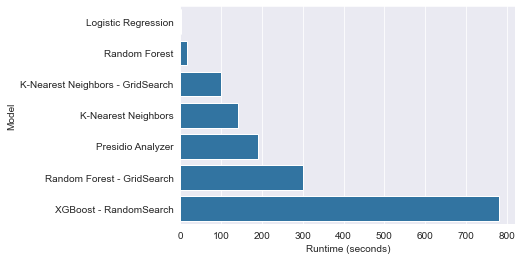

In [101]:
sns.barplot(runtime_df, y='Model', x='Runtime (seconds)')
plt.show()

In [102]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

# Logistic Regression
precision_logreg, recall_logreg, f1_logreg, accuracy_logreg = calculate_metrics(y_valid_argmax, y_pred_logreg)

# Random Forest
precision_rf, recall_rf, f1_rf, accuracy_rf = calculate_metrics(y_valid, y_pred_rf)
precision_rf_grid, recall_rf_grid, f1_rf_grid, accuracy_rf_grid = calculate_metrics(y_valid, pred_rf_grid)

# KNN
precision_knn, recall_knn, f1_knn, accuracy_knn = calculate_metrics(y_valid, y_pred_knn)
precision_knn_grid, recall_knn_grid, f1_knn_grid, accuracy_knn_grid = calculate_metrics(y_valid, y_pred_knn_grid)

# XGBoost
precision_xgb, recall_xgb, f1_xgb, accuracy_xgb = calculate_metrics(y_valid_argmax, y_pred_xgb)

# Presidio Analyzer
#precision_pres, recall_pres, f1_pres, accuracy_pres = calculate_metrics(predicted_results, ground_truth)

models_metrics = {
    'Logistic Regression':
        {'Precision': precision_logreg, 'Recall': recall_logreg, 'F1-score': f1_logreg, 'Accuracy': accuracy_logreg},
    'Random Forest':
        {'Precision': precision_rf, 'Recall': recall_rf, 'F1-score': f1_rf, 'Accuracy': accuracy_rf},
    'Random Forest - GridSearch':
        {'Precision': precision_rf_grid, 'Recall': recall_rf_grid, 'F1-score': f1_rf_grid, 'Accuracy': accuracy_rf_grid},
    'K-Nearest Neighbors':
        {'Precision': precision_knn, 'Recall': recall_knn, 'F1-score': f1_knn, 'Accuracy': accuracy_knn},
    'K-Nearest Neighbors - GridSearch':
        {'Precision': precision_knn_grid, 'Recall': recall_knn_grid, 'F1-score': f1_knn_grid, 'Accuracy': accuracy_knn_grid},
    'XGBoost - RandomSearch':
        {'Precision': precision_xgb, 'Recall': recall_xgb, 'F1-score': f1_xgb, 'Accuracy': accuracy_xgb}
#    'Presidio Analyzer':
#        {'Precision': precision_pres, 'Recall': recall_pres, 'F1-score': f1_pres, 'Accuracy': accuracy_pres}
}

# Convert the dictionary to a pandas DataFrame
model_valid_metrics_df = pd.DataFrame(models_metrics)
model_valid_metrics_df = round(model_valid_metrics_df, 4)
model_valid_metrics_df

,Logistic Regression,Random Forest,Random Forest - GridSearch,K-Nearest Neighbors,K-Nearest Neighbors - GridSearch,XGBoost - RandomSearch
Precision,0.7405,0.8859,0.7810,0.9897,0.9897,0.8118
Recall,0.8605,0.7815,0.7810,0.7827,0.7827,0.8642
F1-score,0.7960,0.7821,0.7810,0.7843,0.7843,0.8088
Accuracy,0.8605,0.8605,0.8605,0.8612,0.8612,0.8642


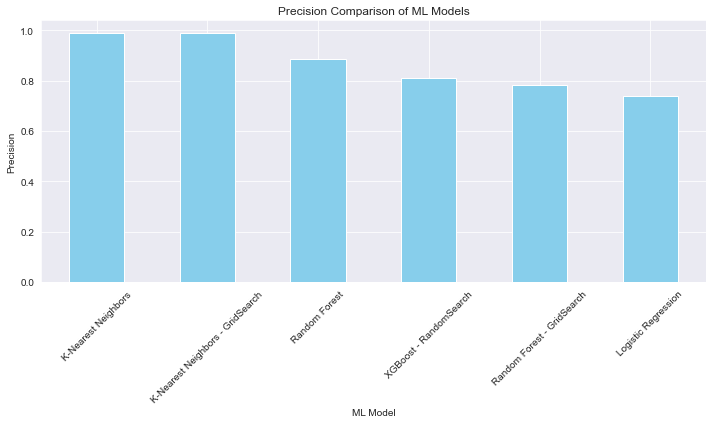

In [111]:
transposed_df = model_valid_metrics_df.transpose()

precision_values = transposed_df.loc[:, 'Precision'].sort_values(ascending=False)
recall_values = transposed_df.loc[:, 'Recall'].sort_values(ascending=False)
f1_values = transposed_df.loc[:, 'F1-score'].sort_values(ascending=False)
accuracy_values = transposed_df.loc[:, 'Accuracy'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
precision_values.plot(kind='bar', color='skyblue')
plt.title('Precision Comparison of ML Models')
plt.xlabel('ML Model')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

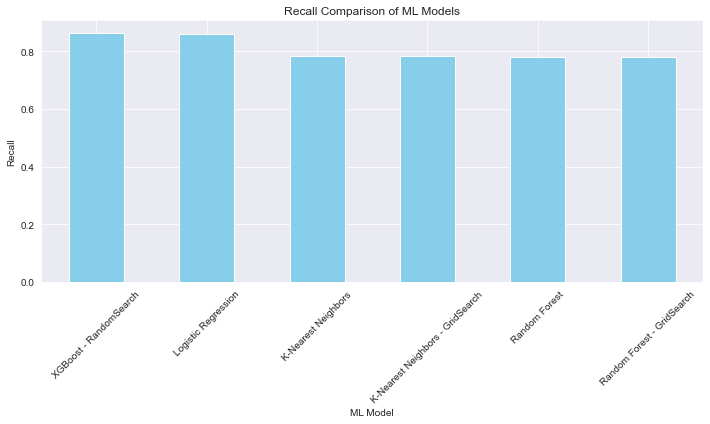

In [112]:
plt.figure(figsize=(10, 6))
recall_values.plot(kind='bar', color='skyblue')
plt.title('Recall Comparison of ML Models')
plt.xlabel('ML Model')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

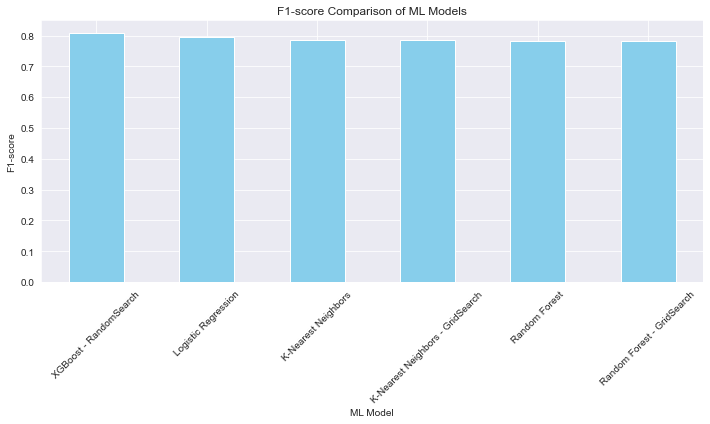

In [113]:
plt.figure(figsize=(10, 6))
f1_values.plot(kind='bar', color='skyblue')
plt.title('F1-score Comparison of ML Models')
plt.xlabel('ML Model')
plt.ylabel('F1-score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

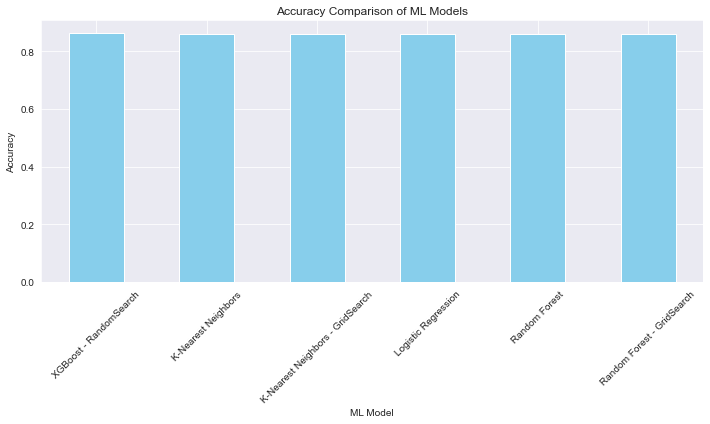

In [114]:
plt.figure(figsize=(10, 6))
accuracy_values.plot(kind='bar', color='skyblue')
plt.title('Accuracy Comparison of ML Models')
plt.xlabel('ML Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()